## The modules below are required in all scripts that train and test neural networks on images

In [1]:
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, models, datasets
from PIL import Image 

### Randomly split a fileset into training, validation, and test sets: output lists of image names

In [2]:
# Set the folder with the samples (images) that compose a dataset

orig_dir   = './images/corel'

# Set the desired image size for rescaling and maximum value for normalization

xsize      = 224 
ysize      = 224
nchannels  = 3
maxval     = 255. 

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.30
valid_perc = 0.30
test_perc  = 0.40

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

### Create image datasets with some preprocessing: output a list of image tensors

In [3]:
# Regular preprocessing transformation. The input is a PIL image, which after being resized, 
# it is converted into a tensor for normalization using the ImageNet mean and stdev parameters. 

prep = transforms.Compose([
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Such transformations are applied everytime images are loaded from the filename lists in training, validation, 
# and test sets. We will do that during training, then by adding affine transformations and increasing the number 
# of epochs, we are actually implementing data augmentation. 

aug = transforms.Compose([
    transforms.Resize((300,300), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.RandomAffine(degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                            interpolation=transforms.InterpolationMode.BILINEAR, 
                            fill=0),
    transforms.CenterCrop(250),
    transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BILINEAR, 
                      max_size=None, antialias=True),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))   
])

# Create an image dataset by applying one of the preprocessing transformations above

class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset, transform=None):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("/")[-1].split("_")[0])-1 for x in self.dataset]
        self.transform = transform
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        if (self.transform is not None):
            image = self.transform(image)
        else: # just reshape the image as a tensor with nchannels, height, width
            image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target) 


### Visualize selected images

Number of images: 106
Images are 224x224x3
Class of the image:  1


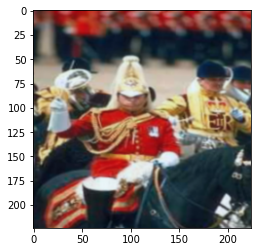

In [4]:
# visualize images from the trainset

datatensor = ImageDataset(trainset, aug)
print("Number of images:", len(datatensor))
image, target = datatensor[100] # it executes getitem
nchannels = image.shape[0]
height    = image.shape[1]
width     = image.shape[2]
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

### Create functions that return random batches from the image lists in the training, validation, and test sets

In [5]:
batchsize = 32

def GetBatches(dataset, batchsize, transformation):
    datatensor = ImageDataset(dataset, transformation) 
    dataloader = DataLoader(datatensor, batch_size=batchsize, shuffle=True)
    return(dataloader)

# as transformations, you may choose None, prep, or aug. However, aug applies to the training set only
trainload = GetBatches(trainset, batchsize, aug)  
validload = GetBatches(validset, batchsize, prep)
testload  = GetBatches(testset, batchsize, prep) 

### When the user calls GetBatches on the training set, for instance, data augmentation is applied in ImageDataSet and DataLoader simply shuffles the image tensors and divide them into batches with 32 images. There is no need to save the augmented set of image tensors but more epochs will be required to train the model.  